In [1]:
raw_dataset_dir = 'dataset_raw'
output_dataset_dir = 'dataset'

In [2]:
#import torch
from IPython.display import Image  # for displaying images
import os 
import random
import shutil
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET
from xml.dom import minidom
#from tqdm import tqdm
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

In [4]:
xml_dir = f'{raw_dataset_dir}/Annotations'
required_names = ['motorbike', 'chair']


def filter_annotations(input_dir, required_names):
    matching_files = defaultdict(list)

    print('All files:', len(os.listdir(xml_dir)))

    for filename in os.listdir(xml_dir):
        file_appended = {key: False for key in required_names}
        if filename.endswith('.xml'):
            file_path = os.path.join(xml_dir, filename)
            tree = ET.parse(file_path)
            root = tree.getroot()

            for obj in root.findall('object'):
                name = obj.find('name').text
                for required_name in required_names:
                    if name == required_name:
                        if not file_appended[name]:
                            matching_files[name].append(os.path.splitext(filename)[0])
                            file_appended[name] = True

    print("Matching files:")
    for k, v in matching_files.items():
        print(k, len(v))
    
    return matching_files

annotations_raw = filter_annotations(xml_dir, required_names)

All files: 22263
Matching files:
motorbike 575
chair 1367


In [5]:
annotations = set()
annotations_duplicates = []
for filenames in annotations_raw.values():
    for filename in filenames:
        if filename not in annotations: 
            annotations.add(filename)
        else:
            print('Duplicate:', filename)
            annotations_duplicates.append(filename)

print('Total duplicates:', len(annotations_duplicates))
print('Deduplicated files:', len(annotations))

Duplicate: 2007_009084
Duplicate: 2008_000981
Duplicate: 2010_005620
Duplicate: 2007_005212
Duplicate: 2009_003722
Duplicate: 2009_003351
Duplicate: 2009_004849
Duplicate: 2011_001524
Total duplicates: 8
Deduplicated files: 1934


In [8]:
print(annotations)

{'2011_000689', '2011_003103', '2008_007935', '2011_002270', '2008_005136', '2008_001147', '2008_003334', '2008_002789', '2009_004734', '2010_003861', '2008_000689', '2010_000244', '2010_005346', '2011_000843', '2010_001455', '2008_004487', '2008_006989', '2007_009521', '2008_004384', '2011_002394', '2008_005213', '2008_006857', '2010_005619', '2008_000381', '2008_006271', '2011_002298', '2007_000661', '2009_002443', '2010_004515', '2011_002714', '2009_001061', '2008_007138', '2011_001842', '2008_002804', '2008_000583', '2008_000803', '2010_004023', '2010_004942', '2009_000730', '2008_007313', '2010_004509', '2008_007356', '2008_003590', '2007_008407', '2009_002841', '2008_000089', '2011_000233', '2009_000212', '2007_001901', '2007_009209', '2009_000980', '2011_001567', '2010_005433', '2011_000651', '2008_003378', '2009_002180', '2010_003856', '2010_005501', '2008_007488', '2008_006350', '2009_000214', '2011_001508', '2008_005139', '2009_002556', '2009_002571', '2008_004970', '2010_005

In [6]:
raw_jpeg_dir = f'{raw_dataset_dir}/JPEGImages'
output_jpeg_dir = f'{output_dataset_dir}/JPEGImages'

def filter_jpegs(input_dir, output_dir, annotations):
    os.makedirs(output_dir, exist_ok=True)

    for filepath in annotations:
            src = f'{input_dir}/{filepath}.jpg'
            out = f'{output_dir}/{filepath}.jpg'
            shutil.copy(src, out)

filter_jpegs(raw_jpeg_dir, output_jpeg_dir, annotations)

In [7]:
raw_annotation_dir = f'{raw_dataset_dir}/Annotations'
output_annotation_dir = f'{output_dataset_dir}/annotations_detection'

def extract_info_from_xml(xml_file):
    root = ET.parse(xml_file).getroot()

    info_dict = {}
    info_dict['bboxes'] = []

    for elem in root:
        if elem.tag == "filename":
            info_dict['filename'] = elem.text

        elif elem.tag == "size":
            image_size = []
            for subelem in elem:
                image_size.append(int(subelem.text))

            info_dict['image_size'] = tuple(image_size)

        elif elem.tag == "object":
            bbox = {}
            for subelem in elem:
                if subelem.tag == "name":
                    bbox["class"] = subelem.text

                elif subelem.tag == "bndbox":
                    for subsubelem in subelem:
                        bbox[subsubelem.tag] = int(subsubelem.text)            
            info_dict['bboxes'].append(bbox)

    return info_dict

print(extract_info_from_xml(f'{raw_annotation_dir}/2010_004952.xml'))

{'bboxes': [{'class': 'chair', 'xmax': 26, 'xmin': 1, 'ymax': 209, 'ymin': 147}, {'class': 'chair', 'xmax': 332, 'xmin': 238, 'ymax': 325, 'ymin': 78}, {'class': 'person', 'xmax': 236, 'xmin': 1, 'ymax': 325, 'ymin': 83}, {'class': 'person', 'xmax': 481, 'xmin': 285, 'ymax': 325, 'ymin': 33}], 'filename': '2010_004952.jpg', 'image_size': (3, 325, 500)}


In [8]:
class_name_to_id_mapping = {name: id for id, name in enumerate(required_names)}

def convert_to_yolov5(info_dict, output_dir):
    print_buffer = []

    for b in info_dict["bboxes"]:
        try:
            class_id = class_name_to_id_mapping[b["class"]]
        except KeyError:
            continue

        b_center_x = (b["xmin"] + b["xmax"]) / 2 
        b_center_y = (b["ymin"] + b["ymax"]) / 2
        b_width    = (b["xmax"] - b["xmin"])          
        b_height   = (b["ymax"] - b["ymin"])

        if info_dict["image_size"][0] == 3:
            image_c, image_h, image_w = info_dict["image_size"]
        else:
            image_w, image_h, image_c = info_dict["image_size"]  
        b_center_x /= image_w
        b_center_y /= image_h
        b_width    /= image_w
        b_height   /= image_h

        print_buffer.append("{} {:.3f} {:.3f} {:.3f} {:.3f}".format(class_id, b_center_x, b_center_y, b_width, b_height))

    save_file_name = os.path.join(output_dir, info_dict["filename"].replace("jpg", "txt"))

    print("\n".join(print_buffer), file= open(save_file_name, "w"))

In [9]:
def convert_to_yolo_format():
    os.makedirs(output_annotation_dir, exist_ok=True)
    for filename in annotations:
        xml_file = f'{raw_annotation_dir}/{filename}.xml'
        print(xml_file)
        convert_to_yolov5(extract_info_from_xml(f'{raw_annotation_dir}/{filename}.xml'), output_annotation_dir)

convert_to_yolo_format()

dataset_raw/Annotations/2011_002796.xml
dataset_raw/Annotations/2007_008994.xml
dataset_raw/Annotations/2008_004619.xml
dataset_raw/Annotations/2010_003103.xml
dataset_raw/Annotations/2008_003726.xml
dataset_raw/Annotations/2009_004849.xml
dataset_raw/Annotations/2010_006010.xml
dataset_raw/Annotations/2008_004071.xml
dataset_raw/Annotations/2008_004077.xml
dataset_raw/Annotations/2008_003774.xml
dataset_raw/Annotations/2008_006841.xml
dataset_raw/Annotations/2011_001456.xml
dataset_raw/Annotations/2010_001699.xml
dataset_raw/Annotations/2008_005000.xml
dataset_raw/Annotations/2008_004611.xml
dataset_raw/Annotations/2008_006606.xml
dataset_raw/Annotations/2010_003529.xml
dataset_raw/Annotations/2009_003873.xml
dataset_raw/Annotations/2008_005433.xml
dataset_raw/Annotations/2009_000629.xml
dataset_raw/Annotations/2011_000755.xml
dataset_raw/Annotations/2011_002953.xml
dataset_raw/Annotations/2009_004452.xml
dataset_raw/Annotations/2009_003668.xml
dataset_raw/Annotations/2008_004697.xml


In [10]:
annotations = [os.path.join(output_annotation_dir, x) for x in os.listdir(output_annotation_dir) if x[-3:] == "txt"]
print('Len', len(annotations))
print(annotations[0])

Len 1934
dataset/annotations_detection/2008_000941.txt


dataset/JPEGImages/2010_005272.jpg


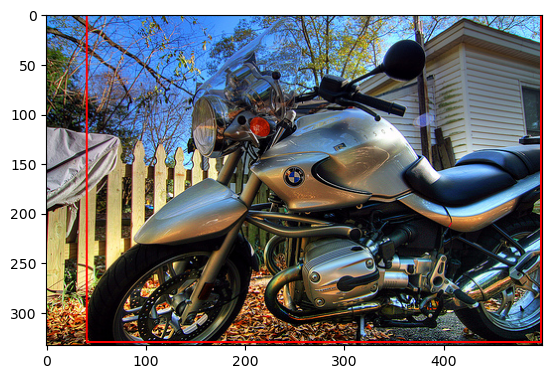

[[0.0, 0.539, 0.498, 0.918, 0.991]]


In [11]:
from IPython.display import Image
from PIL import Image, ImageDraw

#random.seed(6)

class_id_to_name_mapping = dict(zip(class_name_to_id_mapping.values(), class_name_to_id_mapping.keys()))

def plot_bounding_box(image, annotation_list):
    annotations = np.array(annotation_list)
    w, h = image.size

    plotted_image = ImageDraw.Draw(image)

    transformed_annotations = np.copy(annotations)
    transformed_annotations[:,[1,3]] = annotations[:,[1,3]] * w
    transformed_annotations[:,[2,4]] = annotations[:,[2,4]] * h 

    transformed_annotations[:,1] = transformed_annotations[:,1] - (transformed_annotations[:,3] / 2)
    transformed_annotations[:,2] = transformed_annotations[:,2] - (transformed_annotations[:,4] / 2)
    transformed_annotations[:,3] = transformed_annotations[:,1] + transformed_annotations[:,3]
    transformed_annotations[:,4] = transformed_annotations[:,2] + transformed_annotations[:,4]

    for ann in transformed_annotations:
        obj_cls, x0, y0, x1, y1 = ann
        plotted_image.rectangle(((x0,y0), (x1,y1)), outline='red', width=2)

        plotted_image.text((x0, y0 - 10), class_id_to_name_mapping[(int(obj_cls))])

    plt.imshow(np.array(image))
    plt.show()

# Get any random annotation file 
annotation_file = random.choice(annotations)
with open(annotation_file, "r") as file:
    annotation_list = file.read().split("\n")[:-1]
    annotation_list = [x.split(" ") for x in annotation_list]
    annotation_list = [[float(y) for y in x ] for x in annotation_list]

#Get the corresponding image file
image_file = annotation_file.replace("annotations_detection", "JPEGImages").replace("txt", "jpg")
print(image_file)
assert os.path.exists(image_file)

#Load the image
image = Image.open(image_file)

#Plot the Bounding Box
plot_bounding_box(image, annotation_list)
print(annotation_list)

In [12]:
# Read images and annotations
images = [os.path.join(output_jpeg_dir, x) for x in os.listdir(output_jpeg_dir) if x[-3:] == 'jpg']
annotations = [os.path.join(output_annotation_dir, x) for x in os.listdir(output_annotation_dir) if x[-3:] == "txt"]

images.sort()
annotations.sort()

# Split the dataset into train-valid-test splits 
train_images, val_images, train_annotations, val_annotations = train_test_split(images, annotations, test_size = 0.2, random_state = 1)
val_images, test_images, val_annotations, test_annotations = train_test_split(val_images, val_annotations, test_size = 0.5, random_state = 1)

In [13]:
!mkdir {output_jpeg_dir}/train {output_jpeg_dir}/val {output_jpeg_dir}/test {output_annotation_dir}/train {output_annotation_dir}/val {output_annotation_dir}/test

In [14]:
#Utility function to move images 
def move_files_to_folder(list_of_files, destination_folder):
    for f in list_of_files:
        try:
            shutil.move(f, destination_folder)
        except:
            print(f)
            assert False

# Move the splits into their folders
move_files_to_folder(train_images, f'{output_jpeg_dir}/train')
move_files_to_folder(val_images, f'{output_jpeg_dir}/val/')
move_files_to_folder(test_images, f'{output_jpeg_dir}/test/')
move_files_to_folder(train_annotations, f'{output_annotation_dir}/train/')
move_files_to_folder(val_annotations, f'{output_annotation_dir}/val/')
move_files_to_folder(test_annotations, f'{output_annotation_dir}/test/')

In [15]:
!pwd
!mv {output_annotation_dir} {output_dataset_dir}/labels

/home/ugnsta3/deepl-3
